<a href="https://colab.research.google.com/github/Sulaiman29/IntelliBrief/blob/main/BDA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IntelliBrief News Summarisation System**

**Installing the required dependencies:**

In [ ]:
pip install fasttext

In [ ]:
pip install rouge-score

**Importing important Libraries:**

In [ ]:
import fasttext
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from scipy import spatial
from statistics import mean
from math import ceil
from rouge_score import rouge_scorer
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Mounting the Google drive, to keep our trained models (Easy to use)**

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/

/content/drive/My Drive


**After training and testing using our saved models to work in a clusterd form**

In [ ]:
!ls "/content/drive/MyDrive/models"

model_cbow.bin	model_skipgram.bin


In [ ]:
model_skipgram = fasttext.load_model("models/model_skipgram.bin")
model_cbow = fasttext.load_model("models/model_cbow.bin")

**Initiating the task:**

In [ ]:
from IPython.display import Image

# Provide the path to your PNG file
image_path = '/content/473172_1_En_16_Fig1_HTML.png'

# Display the image
#Image(filename=image_path)


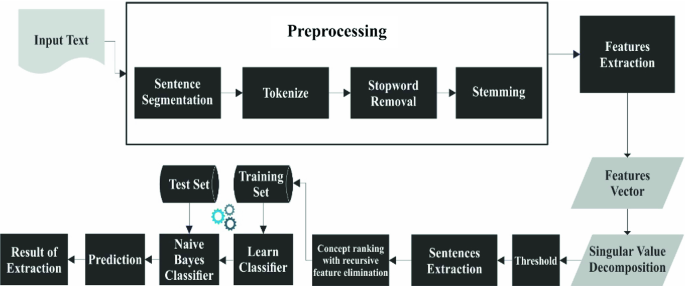

**Unzip the data into respective directory:**

In [ ]:
!unzip -q /content/Dataset.zip -d /content/data

replace /content/data/BBC News Summary/News Articles/business/001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

We begin with the assumption that our input stream is pre-processed, which allows us to apply the Naive Bayes algorithm effectively. We then elaborate the process further by performing feature extraction.

In [ ]:
#Naive baye's classifier:
import pandas as pd #Dataframe Manipulation library
import numpy as np #Data Manipulation library

#sklearn modules for Feature Extraction & Modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Libraries for Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pylab import boxplot, text
import seaborn as sns
import joblib
import os
import glob

In [ ]:
print(f"Current working directory is: {os.getcwd()}")
dir = os.chdir("/content")
print(f'Changing directory to {os.getcwd()}')

Current working directory is: /content/drive/MyDrive
Changing directory to /content


In [ ]:
def load_data(folder_names, root_path):
    fileNames = [path + "/data/BBC News Summary/News Articles/" + folder + '/' + "*.txt"
        for path,folder in zip([root_path]*len(folder_names), folder_names)]
    #print(fileNames)
    #print("\n")
    doc_list = []
    tags = folder_names
    for docs in fileNames:
        #print(docs)
        doc = glob.glob(docs)#glob method iterates through all files and reads the text in documents in the folders
        for text in doc:
            with open(text, encoding="latin-1") as f:
                topic = docs.split('/')[len(docs.split('/'))-2]
                lines = f.readlines()
                heading = lines[0].strip()#stripping the text by spaces and using first element into heading
                body = ' '.join([l.strip() for l in lines[1:]])
                doc_list.append([topic,heading,body])
        print(f"Loading data from \033[1m{topic}\033[0m directory")
    print("\nEntire Data is loaded successfully")

    return doc_list

In [ ]:
folder_names = ['business','entertainment','politics','sport','tech']
docs = load_data(folder_names=folder_names,root_path=os.getcwd())

Loading data from business directory
Loading data from entertainment directory
Loading data from politics directory
Loading data from sport directory
Loading data from tech directory

Entire Data is loaded successfully


In [ ]:
docs = pd.DataFrame(docs, columns = ['Category','Heading','Article'])

In [ ]:
docs.head()

,Category,Heading,Article
0,business,UK homes hit Â£3.3 trillion total,The value of the UK's housing stock reached t...
1,business,Why few targets are better than many,The economic targets set out at the Lisbon su...
2,business,GE sees 'excellent' world economy,US behemoth General Electric has posted an 18...
3,business,Giving financial gifts to children,Your child or grandchild may want the latest ...
4,business,Iraq and Afghanistan in WTO talks,The World Trade Organisation (WTO) is to hold...


In [ ]:
docs['text_len']=docs.Heading.apply(len)
docs['headlines_len']=docs.Article.apply(len)

<Axes: xlabel='Category'>

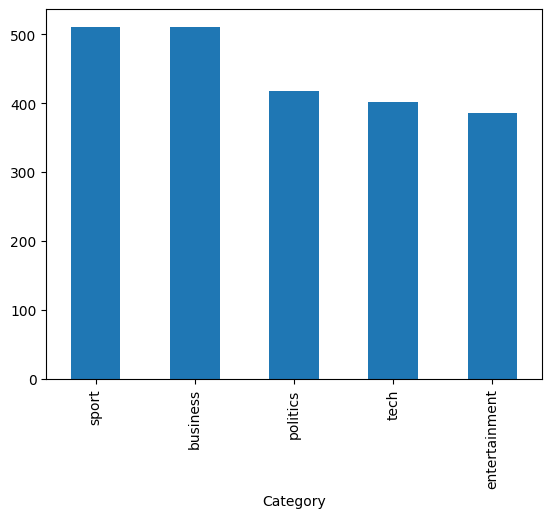

In [ ]:
docs['Category'].value_counts().plot.bar()

In [ ]:
docs.head()

,Category,Heading,Article,text_len,headlines_len
0,business,UK homes hit Â£3.3 trillion total,The value of the UK's housing stock reached t...,33,1350
1,business,Why few targets are better than many,The economic targets set out at the Lisbon su...,36,5116
2,business,GE sees 'excellent' world economy,US behemoth General Electric has posted an 18...,33,1384
3,business,Giving financial gifts to children,Your child or grandchild may want the latest ...,34,4580
4,business,Iraq and Afghanistan in WTO talks,The World Trade Organisation (WTO) is to hold...,33,1616


<Axes: xlabel='headlines_len', ylabel='Count'>

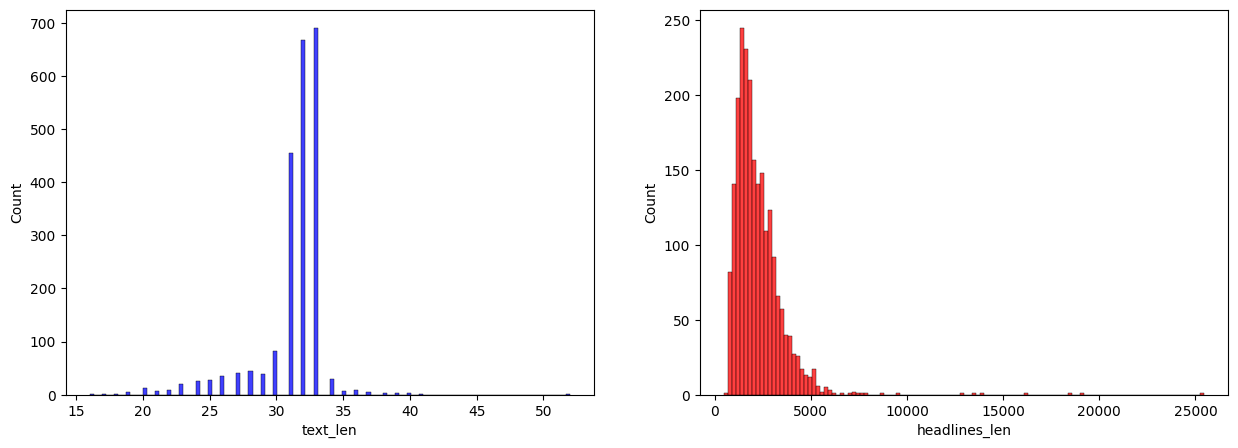

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(docs.text_len, ax=axes[0], color='blue')
sns.histplot(docs.headlines_len, ax=axes[1], color='red')

In [ ]:
tags_values = docs.Category.value_counts()
tags_values

,count
Category,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [ ]:
def plot_boxplot(df, varibale):
  fig1, ax1 = plt.subplots(figsize=(10,2))
  ax1.set_title(f'BoxPlot of {variable}', fontsize=18)
  values = list(df[variable].values)
  ax1.boxplot(values, vert=False, showfliers=False, widths = 0.6);

  bp_dict = boxplot(values, vert=False, showfliers=False, widths = 0.6)


  for line in bp_dict['medians']:
      # get position data for median line
      x, y = line.get_xydata()[1] # top of median line
      # overlay median value
      text(x, y+0.05, '%.1f' % x,
          horizontalalignment='center', fontsize=14) # draw above, centered

  for line in bp_dict['whiskers']:
      # get position data for median line
      x, y = line.get_xydata()[1] # top of median line
      # overlay median value
      text(x, y+0.3, '%.1f' % x,
          horizontalalignment='center', fontsize=14) # draw above, centered

  for line in bp_dict['boxes']:
      x, y = line.get_xydata()[0] # bottom of left line
      text(x,y-0.02, '%.1f' % x,
          horizontalalignment='center', # centered
          verticalalignment='top', fontsize=14)      # below
      x, y = line.get_xydata()[3] # bottom of right line
      text(x,y-0.02, '%.1f' % x,
          horizontalalignment='center', # centered
              verticalalignment='top', fontsize=14)      # below

  plt.xlabel(variable, fontsize=10)
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.show()

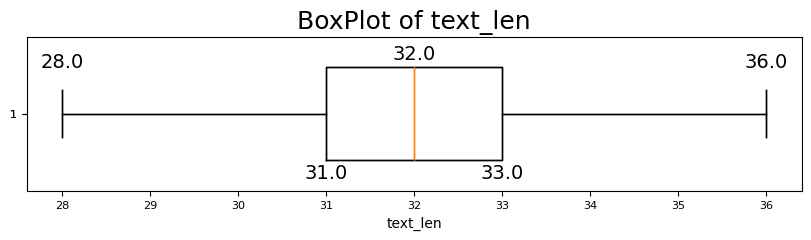

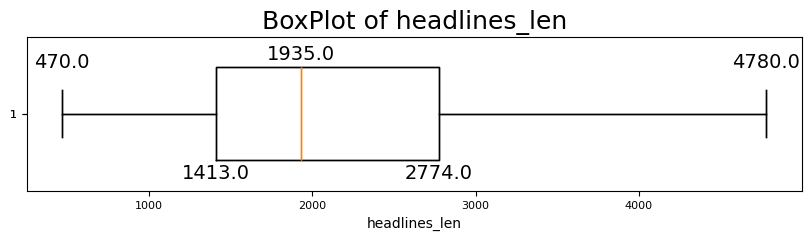

In [ ]:
for variable in ['text_len','headlines_len']:
  plot_boxplot(docs, variable)

In [ ]:
#Creating a list of text belonging to individual category of articles

heading_sport = docs[docs["Category"]=='sport']["Heading"] #Extracting the headings of the
#print(heading_sport)
collapsed_heading_sport =heading_sport.str.cat(sep = ' ') #
#print(collapsed_heading_sport)

heading_business = docs[docs["Category"]=='business']["Heading"] #Extracting the headings
collapsed_heading_business =heading_business.str.cat(sep = ' ')

heading_politics = docs[docs["Category"]=='politics']["Heading"]
collapsed_heading_politics =heading_politics.str.cat(sep = ' ')

heading_tech = docs[docs["Category"]=='tech']["Heading"]
collapsed_heading_tech =heading_tech.str.cat(sep = ' ')

heading_entertainment = docs[docs["Category"]=='entertainment']["Heading"]
collapsed_heading_entertainment =heading_entertainment.str.cat(sep = ' ')

In [ ]:
#Creating List of Stopwords
stopwords = set(STOPWORDS)


Sports


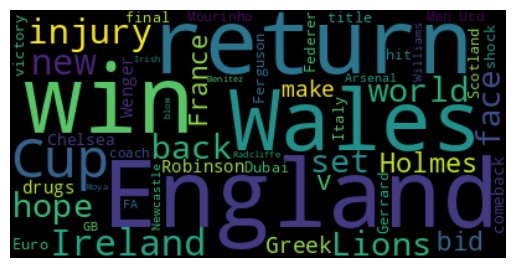


Business


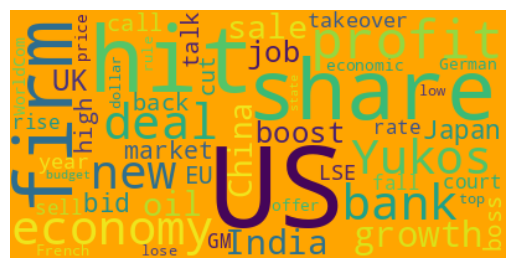

In [ ]:
print('\033[1m'"\nSports"'\033[0m')
#Generate a Word Cloud for Sports
wordcloud = WordCloud(stopwords=stopwords, background_color='black', max_words=50).generate(collapsed_heading_sport)#Initializing the Word Cloud Class
#Display the generated Word cloud as image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


print('\033[1m'"\nBusiness"'\033[0m')
#Generate a Word Cloud for Business
wordcloud = WordCloud(stopwords=stopwords, background_color='orange', max_words=50).generate(collapsed_heading_business)#Initializing the Word Cloud Class
#Display the generated Word cloud as image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
"""
 Finally, the transformed data is fed into a
 Multinomial Naive Bayes classifier to predict the
 category or label of the input text.
"""
#Building pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()), #Apply the transformed data to Multinomial Naive Bayes Algo
])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(docs['Heading'],docs['Category'],
                                                   random_state=42, test_size=0.2)
print(f"Size of input training data is {x_train.shape}")
print(f"Size of input test data is {x_test.shape}")
print(f"Size of output training data is {y_train.shape}")
print(f"Size of output test data is {y_test.shape}")

Size of input training data is (1780,)
Size of input test data is (445,)
Size of output training data is (1780,)
Size of output test data is (445,)


In [ ]:
model = clf.fit(x_train,y_train) #fit the clf pipeline to training data

In [ ]:
#Accuracy of the Naive Bayes Model
mdl_score = "{:.2f}".format(model.score(x_test,y_test) * 100)
print(f"The Accuracy of the Naive Bayes Classifier Model is {mdl_score}%")
print(f"\n{mdl_score}% of the times the model predicts the correct category for the news article")

The Accuracy of the Naive Bayes Classifier Model is 83.82%

83.82% of the times the model predicts the correct category for the news article


In [ ]:
#Predicting on the test data
y_pred_NB = model.predict(x_test)
y_pred_NB[:5]


array(['business', 'tech', 'sport', 'business', 'politics'], dtype='<U13')

In [ ]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat


array([[97,  3,  3,  9,  3],
       [ 6, 50,  3, 10,  3],
       [ 5,  1, 65,  3,  2],
       [ 4,  2,  2, 92,  2],
       [ 5,  3,  0,  3, 69]])

In [ ]:
import itertools

def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title = "Confusion Matrix",
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")

    print(cm)
#show data as image using plt.imshow
    plt.imshow(cm,interpolation='nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
#ARANGE : returns evenly spaced values from the given interval
# and the advantage of numpy.arange() over the normal in-built range() function is that it allows us to generate sequences of numbers that are not integers
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.xlabel = 'True Article Category'
    plt.ylabel = 'Predicted Article Category'



Confusion Matrix, without Normalization
[[97  3  3  9  3]
 [ 6 50  3 10  3]
 [ 5  1 65  3  2]
 [ 4  2  2 92  2]
 [ 5  3  0  3 69]]
Normalized Confusion Matrix
[[0.84 0.03 0.03 0.08 0.03]
 [0.08 0.69 0.04 0.14 0.04]
 [0.07 0.01 0.86 0.04 0.03]
 [0.04 0.02 0.02 0.9  0.02]
 [0.06 0.04 0.   0.04 0.86]]


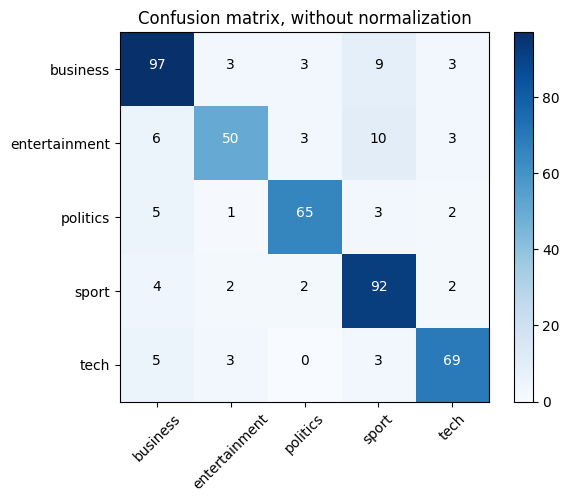

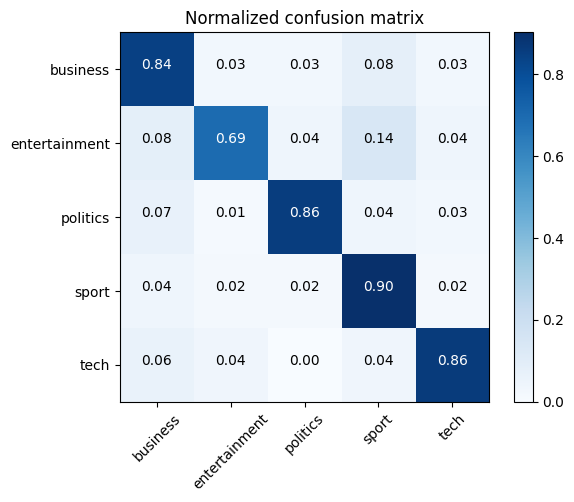

In [ ]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_mat, classes=['business','entertainment','politics','sport','tech'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_mat,['business','entertainment','politics','sport','tech'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

95 true positives were predicted for class 0, 2 false positives were predicted for class 0, 10 false negatives were predicted for class 0, and 4 false negatives were predicted for class 0.
59 true positives were predicted for class 1, 2 false positives were predicted for class 1, 1 false negative was predicted for class 1, and 7 false negatives were predicted for class 1.
63 true positives were predicted for class 2, 8 false positives were predicted for class 2, 3 false negatives were predicted for class 2, and 2 false negatives were predicted for class 2.
87 true positives were predicted for class 3, 9 false positives were predicted for class 3, 3 false negatives were predicted for class 3, and 2 false negatives were predicted for class 3.
69 true positives were predicted for class 4, 5 false positives were predicted for class 4, 0 false negatives were predicted for class 4, and 4 false negatives were predicted for class 4.

**Decision Tree Classifier**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier()), #Apply the transformed data to Multinomial Naive Bayes Algo
])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(docs['Heading'],docs['Category'],
                                                   random_state=42, test_size=0.2)
print(f"Size of input training data is {x_train.shape}")
print(f"Size of input test data is {x_test.shape}")
print(f"Size of output training data is {y_train.shape}")
print(f"Size of output test data is {y_test.shape}")

Size of input training data is (1780,)
Size of input test data is (445,)
Size of output training data is (1780,)
Size of output test data is (445,)


In [ ]:
model_Decision_Tree = clf_DT.fit(x_train,y_train)
model_score_Decision_Tree = "{:.2f}".format(model_Decision_Tree.score(x_test,y_test) * 100)
print(f"The Accuracy of the Decision Tree Classifier Model is {model_score_Decision_Tree}%")
print(f"\n{model_score_Decision_Tree}% of the times the model predicts the correct category for the news articles")

The Accuracy of the Decision Tree Classifier Model is 70.56%

70.56% of the times the model predicts the correct category for the news articles


In [ ]:
y_pred_DT = model.predict(x_test)
y_pred_DT[:10]

array(['business', 'tech', 'sport', 'business', 'politics', 'sport',
       'sport', 'politics', 'tech', 'politics'], dtype='<U13')

### **Comparison Analysis:**
Decision Trees tend to have lower accuracy compared to Naive Bayes Model when dealing with high dimensional feature space. Based on the experimental results, the Naive Bayes Classifier Model achieved the highest accuracy with **83.82%**. In contrast, the Decision Tree Classifier Model achieved lower accuracy of **70.34%**, respectively.

**TextRank Algorithm**

In [ ]:
# Provide the path to your PNG file
image_path = '/content/electronics-12-00372-g001.png'

# Display the image
#Image(filename=image_path, width=500, height=500)

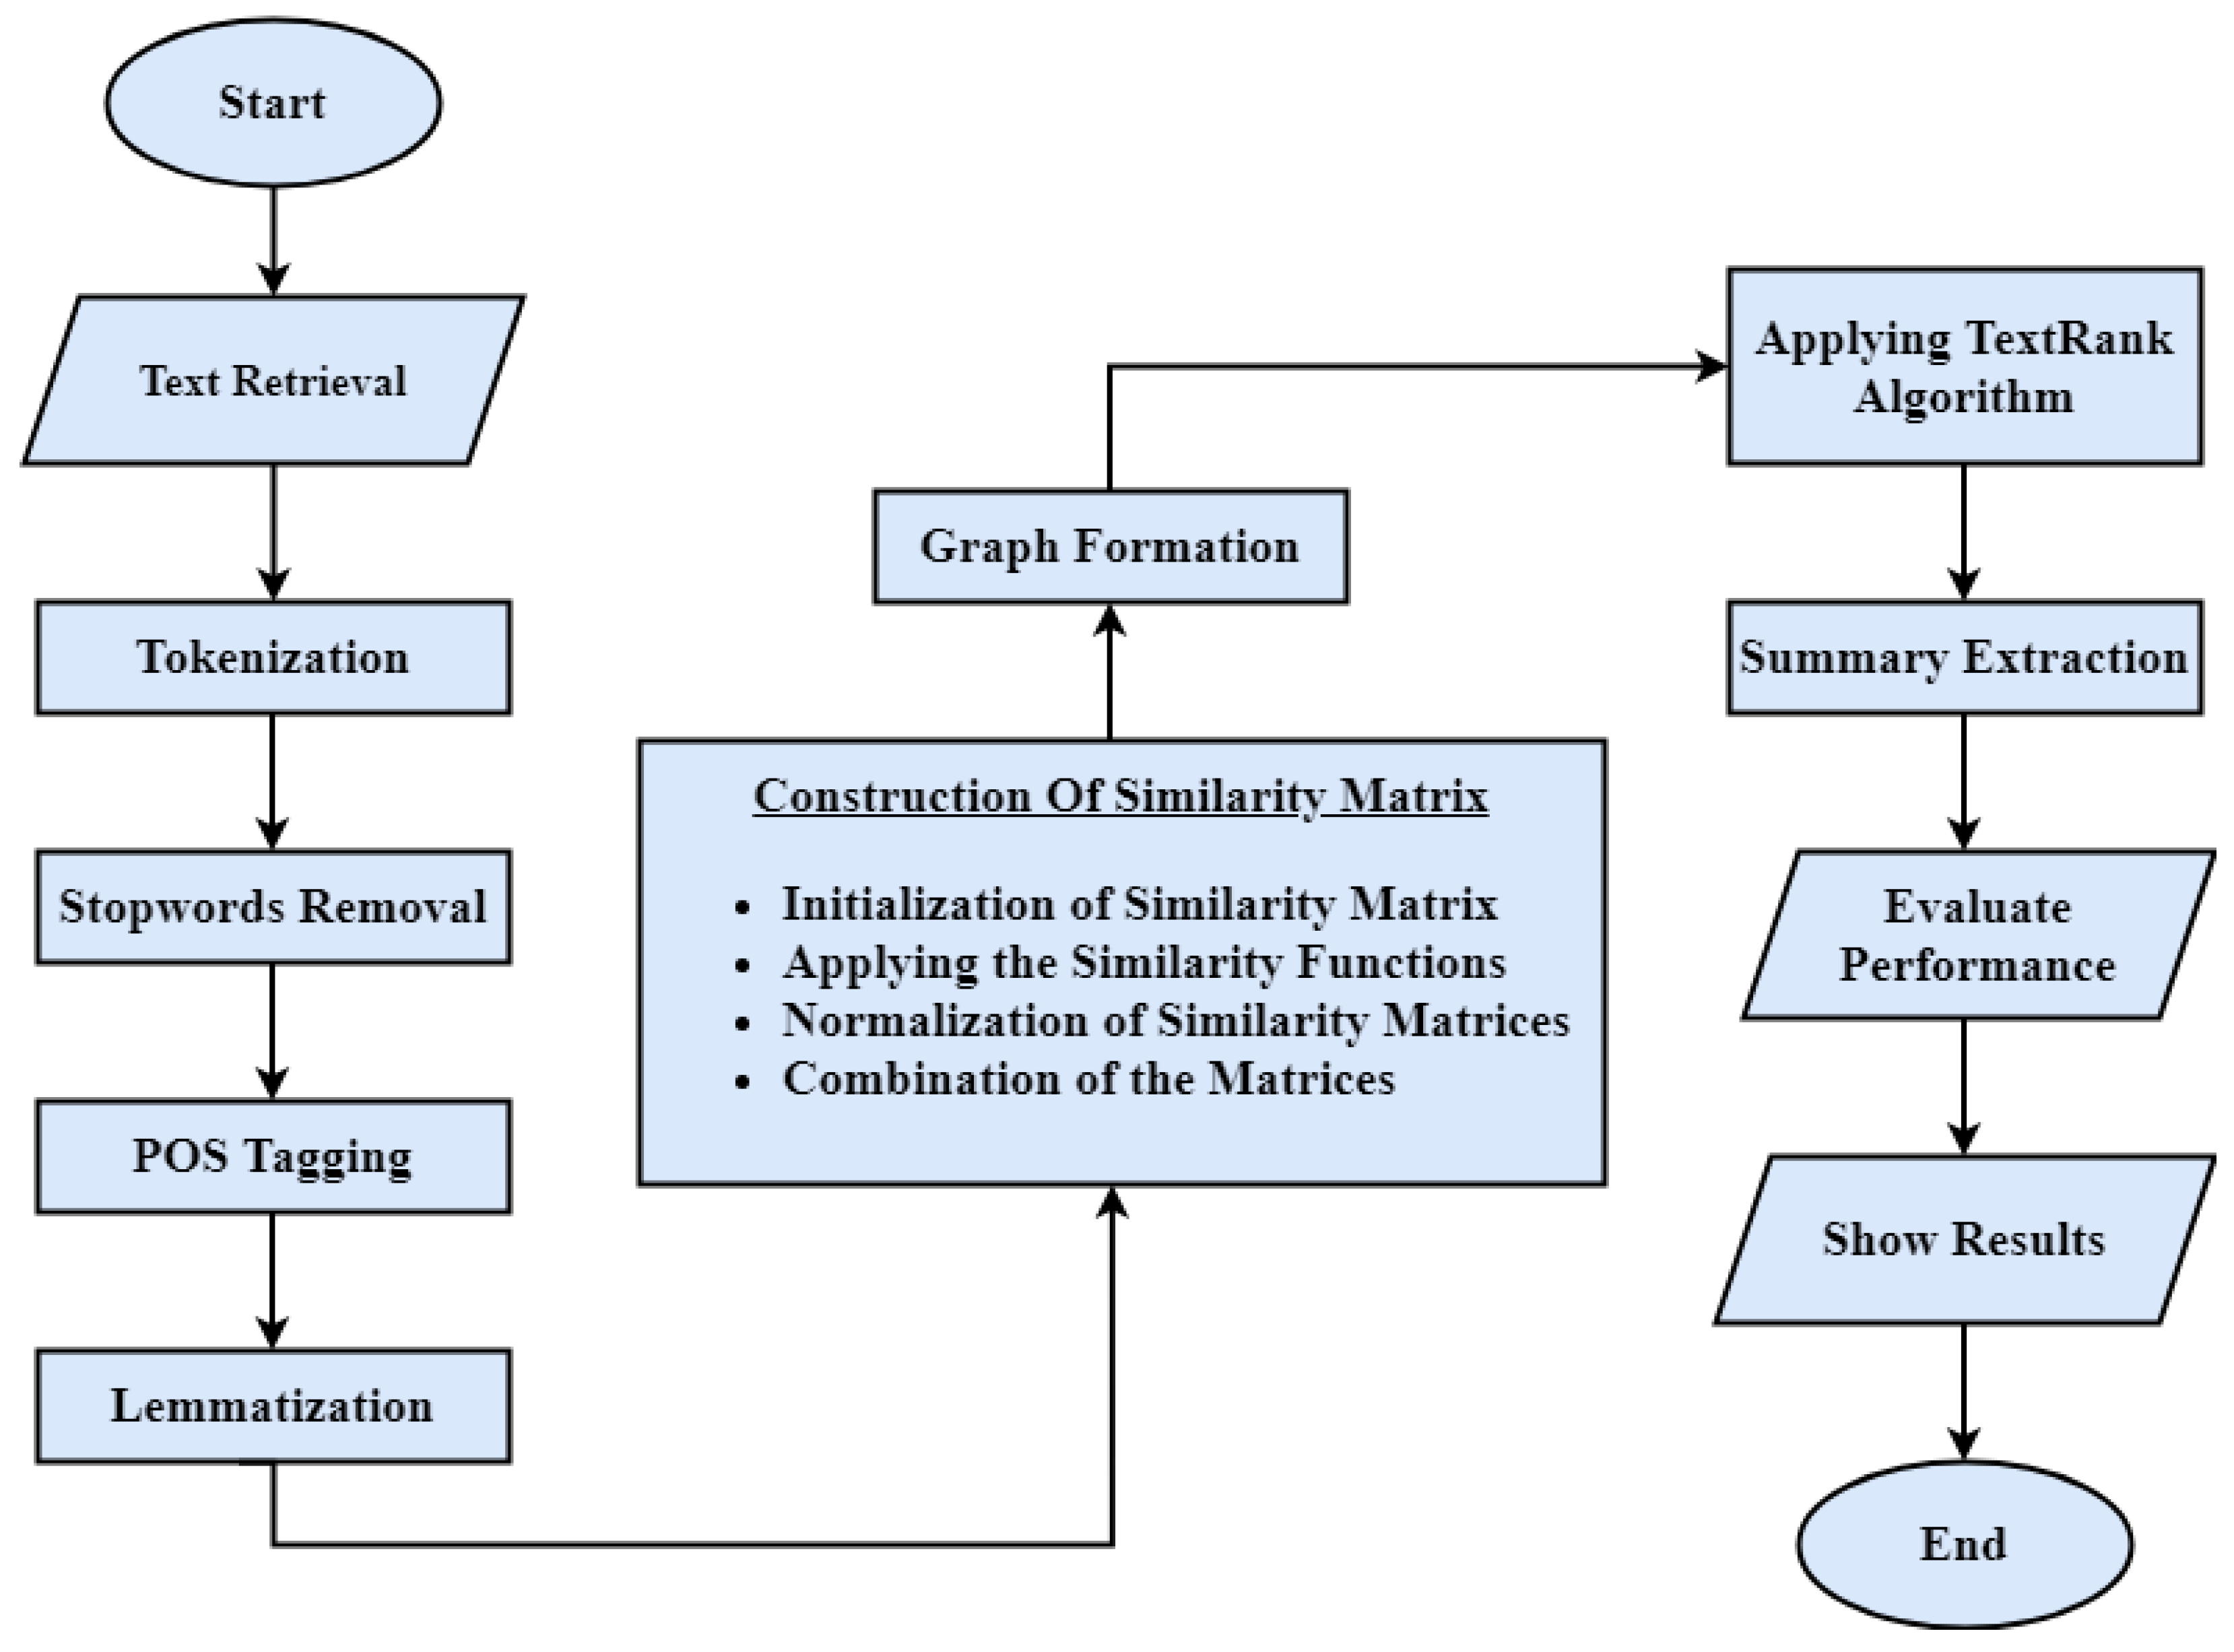

In [ ]:
class SummarizationModel:
  def __init__(self, compression_ratio = 0.4, d = 0.15, model = model_skipgram):
    self.compression_ratio = compression_ratio
    self.d = d
    self.model = model

  def preprocess(self, news):

    #tokenize sentences
    indexes = []
    sentences = sent_tokenize(news)
    og_sentences = []
    for sent in sentences:
      splitting = sent.split('\n')
      for split in splitting:
        split = split.strip()
        og_sentences.append(split)

    while '' in og_sentences:
      og_sentences.remove('')


    #remove stop words
    word_tokenization = [word_tokenize(x) for x in og_sentences]
    stop_words_removal = [list(filter(lambda x: x not in stopwords.words('english'), sent)) for sent in word_tokenization]

    #stemming
    porter = PorterStemmer()
    stemmed_words = [list(map(porter.stem, sent)) for sent in stop_words_removal]
    stemmed_sentences = [" ".join(sentence) for sentence in stemmed_words]

    #further data cleaning
    for i in range(len(stemmed_sentences)):
      stemmed_sentences[i] = stemmed_sentences[i].replace(',', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('.', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('`', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('\'', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('\'s', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(':', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('.', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(';', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('(', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(')', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('-', '')
      stemmed_sentences[i] = stemmed_sentences[i].strip()

    while '' in stemmed_sentences:
      stemmed_sentences.remove('')

    #storing vectors
    sentence_vectors = []
    for i in range(len(stemmed_sentences)):
      vector = self.model.get_word_vector(stemmed_sentences[i])
      sentence_vectors.append((tuple(vector), og_sentences[i]))

    return sentence_vectors

  def cosine_similarity(self, v1, v2):
    return 1 - spatial.distance.cosine(v1,v2)

  def update_scores(self, scores, adj_list, T):
    for node in scores.keys():
      tr = 0
      for adj_node in adj_list[node]:
        tr+=scores[adj_node[0]]/len(adj_list[adj_node[0]])
      TR = self.d/T + (1-self.d)*tr
      scores[node] = TR

  def generateSummary(self, news):
    sentence_vectors = self.preprocess(news)
    adj_list = {}
    sum = 0
    count = 0

    #creating graph
    for i in range(len(sentence_vectors)):
      for j in range(i+1, len(sentence_vectors)):
        if sentence_vectors[i][0] not in adj_list.keys():
          adj_list[sentence_vectors[i][0]] = []
        if sentence_vectors[j][0] not in adj_list.keys():
          adj_list[sentence_vectors[j][0]] = []
        similarity = self.cosine_similarity(sentence_vectors[i][0], sentence_vectors[j][0])
        sum += similarity
        count +=1

        adj_list[sentence_vectors[i][0]].append((sentence_vectors[j][0], similarity))
        adj_list[sentence_vectors[j][0]].append((sentence_vectors[i][0], similarity))

    average = sum/count

    #dropping edges below average
    for key in adj_list.keys():
      for value in adj_list[key]:
        if value[1]<average:
          adj_list[key].remove(value)

    #initialising scores
    scores = {node: mean([x[1] for x in adj_list[node]]) for node in list(adj_list.keys())}
    #updating scores
    for i in range (50) : self.update_scores(scores, adj_list, len(adj_list))
    #sorting nodes by score
    sorted_score = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))

    #obtaining original sentences
    sentences = []
    for key in sorted_score.keys():
      for i in range(len(sentence_vectors)):
        if key == sentence_vectors[i][0]:
          sentences.append((sentence_vectors[i][1], i))

    #generating the final summary
    top_sentences = sentences[0:ceil(self.compression_ratio*len(sentence_vectors))]
    top_sentences = sorted(top_sentences, key = lambda x : x[1])
    summary = " ". join([x[0] for x in top_sentences])

    return summary

In [ ]:
#individual testing
#domain = 'sport'
#number = '052'
news_path = f'/content/data/BBC News Summary/News Articles/sport/052.txt'
ans_path = f'/content/data/BBC News Summary/Summaries/sport/052.txt'
f1 = open(news_path, 'r')
f2 = open(ans_path, 'r')
news = f1.read()
answer = f2.read()

model = SummarizationModel()
model.model = model_skipgram
model.compression_ratio = 0.4
model.d = 0.15
summary = model.generateSummary(news)
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(summary,answer)

scores

In [ ]:
answer

In [ ]:
summary

In [ ]:
scores

In [ ]:
#dataset testing
domains =  ['business', 'entertainment', 'politics', 'sport', 'tech']
base_news_path = '/content/data/BBC News Summary/News Articles/'
base_summaries_path = '/content/data/BBC News Summary/Summaries/'
news_list = []
summaries_list = []
name_list = []
exceptions = []
for domain in domains:
  news_path = base_news_path + domain + '/'
  summary_path = base_summaries_path + domain + '/'
  for name in os.listdir(news_path):
    news_full_path = news_path + name
    summary_full_path = summary_path + name
    f1 = open(news_full_path, "r")
    f2 = open(summary_full_path, "r")
    try:
      news_list.append(f1.read())
      summaries_list.append(f2.read())
      name_list.append(name)
    except:
      exceptions.append(name)
      print(name)
    finally:
      f1.close()
      f2.close()

In [ ]:
len(name_list)

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
rouge_1 = [0,0,0]
rouge_2 = [0,0,0]
rouge_L = [0,0,0]
count = 0
for i in range(len(news_list)):
  my_summary = model.generateSummary(news_list[i])
  scores = scorer.score(my_summary,summaries_list[i])
  rouge_1[0] += scores['rouge1'].precision
  rouge_1[1] += scores['rouge1'].recall
  rouge_1[2] += scores['rouge1'].fmeasure
  rouge_2[0] += scores['rouge2'].precision
  rouge_2[1] += scores['rouge2'].recall
  rouge_2[2] += scores['rouge2'].fmeasure
  rouge_L[0] += scores['rougeL'].precision
  rouge_L[1] += scores['rougeL'].recall
  rouge_L[2] += scores['rougeL'].fmeasure
  if scores['rouge1'].precision<0.5:
    print(name_list[i])
  count+=1

rouge_1 = [x/count for x in rouge_1]
rouge_2 = [x/count for x in rouge_2]
rouge_L = [x/count for x in rouge_L]

In [ ]:
rouge_1

In [ ]:
rouge_2

In [ ]:
rouge_L

In [ ]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat

In [ ]:
model = clf.fit(x_train,y_train) #fit the clf pipeline to training data

In [ ]:
#Accuracy of the Naive Bayes Model
mdl_score = "{:.2f}".format(model.score(x_test,y_test) * 100)
print(f"The Accuracy of the Naive Bayes Classifier Model is {mdl_score}%")
print(f"\n{mdl_score}% of the times the model predicts the correct category for the news article")

In [ ]:
#Predicting on the test data
y_pred_NB = model.predict(x_test)
y_pred_NB[:5]

In [ ]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat

In [ ]:
import itertools

def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title = "Confusion Matrix",
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")

    print(cm)
#show data as image using plt.imshow
    plt.imshow(cm,interpolation='nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
#ARANGE : returns evenly spaced values from the given interval
# and the advantage of numpy.arange() over the normal in-built range() function is that it allows us to generate sequences of numbers that are not integers
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.xlabel = 'True Article Category'
    plt.ylabel = 'Predicted Article Category'

In [ ]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_mat, classes=['business','entertainment','politics','sport','tech'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_mat,['business','entertainment','politics','sport','tech'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()